## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
from scipy.linalg import lstsq, solve
%matplotlib qt
%matplotlib inline

## Conversion parameters

In [4]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension

# meters per pixel in x dimension 
# 600 is the actual lane line distance in pixels derived from the perspective transformed image
xm_per_pix = 3.7/600

## Helper Functions

In [41]:
def cal_undistort(img, objpoints, imgpoints):
    """computes the camera calibration matrix and distortion coefficients
    and applies distortion correction to an image"""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #return undistorted image, calibration matrix and distortion coefficients
    return undist, mtx, dist


def color_gradient_thresholding(img, s_thresh=(170, 255), sobel_kernel=3, thresh=(20, 100), thresh_mag=(30,100), thresh_dir=(0, np.pi/2)):
    """applies color and gradient thresholding to image in order to create
    a binary image which likely contains lane-line pixels"""
    
    #calculate x gradient thresholded image
    gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=thresh)
    print("Sobelx, Gradient threshold:")
    plt.imshow(gradx_binary,cmap='gray')
    plt.show()
    
    #calculate y gradient thresholded image
    grady_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel, thresh=thresh)
    print("Sobely, Gradient threshold:")
    plt.imshow(grady_binary,cmap='gray')
    plt.show()
    
    #calculate gradient magnitude thresholded image
    mag_binary = mag_thresh(img, sobel_kernel=sobel_kernel, thresh_mag=thresh_mag)
    print("Gradient mag threshold:")
    plt.imshow(mag_binary,cmap='gray')
    plt.show()
    
    #calculate gradient diretion thresholded image
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, thresh_dir=thresh_dir)
    print("Gradient dir threshold:")
    plt.imshow(dir_binary,cmap='gray')
    plt.show()
    
    #combining gradient threshold techniques
    combined_grad_binary = np.zeros_like(dir_binary)
    combined_grad_binary[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    print("Combined grad threshold:")
    plt.imshow(combined_grad_binary,cmap='gray')
    plt.show()
    
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    print("S channel:")
    plt.imshow(s_channel,cmap='gray')
    plt.show()
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    print("S threshold:")
    plt.imshow(s_binary,cmap='gray')
    plt.show()
    
    # Combine the two binary thresholds (gradient threshold and S channel threshold)
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[(s_binary == 1) | (combined_grad_binary == 1)] = 1
    
    return combined_binary



def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    """Compute directional gradient, apply threshold"""
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print("Grayscale image:")
    plt.imshow(gray,cmap='gray')
    plt.show()
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary


def mag_thresh(img, sobel_kernel=3, thresh_mag=(30, 100)):
    """Compute gradient magnitude, apply threshold"""
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh_mag[0]) & (gradmag <= thresh_mag[1])] = 1

    # Return the binary image
    return mag_binary


def dir_threshold(img, sobel_kernel=3, thresh_dir=(0.7, 1.3)):
    """Compute gradient direction, apply threshold"""
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh_dir[0]) & (absgraddir <= thresh_dir[1])] = 1

    # Return the binary image
    return dir_binary


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def calc_intersections(imshape, p_left, p_right):
    """calculates the intersection coordinates of full lane lines with ROI"""
    
    bottom_left_lane_y = imshape[0] -1
    bottom_left_lane_x = int((bottom_left_lane_y - p_left[0])/p_left[1])
    top_left_lane_y = 470
    top_left_lane_x = int((top_left_lane_y - p_left[0])/p_left[1])
    bottom_right_lane_y = imshape[0] -1
    bottom_right_lane_x = int((bottom_right_lane_y - p_right[0])/p_right[1])
    top_right_lane_y = 470
    top_right_lane_x = int((top_right_lane_y - p_right[0])/p_right[1])
    
    #create a list of tuples each containing an intersection point with coordinates (x,y)
    intersection_vertices = [(bottom_left_lane_x,bottom_left_lane_y),(top_left_lane_x,top_left_lane_y),\
                            (top_right_lane_x,top_right_lane_y),(bottom_right_lane_x,bottom_right_lane_y)]
    
    return intersection_vertices


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    addition: Returns intersection vertices with region of interest
    """
    
    #drawing line segments to img
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    '''
    
    imshape = img.shape
    
    x_left_lane = []
    x_right_lane = []
    y_left_lane = []
    y_right_lane = []
    
    #extension of line segments to full lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #compute slope of each line segment
            m = (y2 - y1)/(x2 - x1)
            
            #distinguish left lane points from right lane points
            if m < 0:
                x_left_lane.append(x1)
                y_left_lane.append(y1)
                x_left_lane.append(x2)
                y_left_lane.append(y2)
                
            elif m > 0:
                x_right_lane.append(x1)
                y_right_lane.append(y1)
                x_right_lane.append(x2)
                y_right_lane.append(y2)
    
    
    #full lines are obtained by solving a ordinary least squares problem mx+b
    #create design matrix M
    M_left_lane = np.array(x_left_lane)[:, np.newaxis]**[0, 1]
    M_right_lane = np.array(x_right_lane)[:, np.newaxis]**[0, 1]
    
    #run least squares
    #p is the vector containing the parameters b and m
    p_left_lane, res, rnk, s = lstsq(M_left_lane, np.array(y_left_lane))
    p_right_lane, res, rnk, s = lstsq(M_right_lane, np.array(y_right_lane))
    
    
    #compute bottom and top intersections of full lane lines with region of interest
    intersection_vertices = calc_intersections(imshape, p_left_lane, p_right_lane)
    
    #draw full lane lines onto image from bottom to top of region of interest
    cv2.line(img, (intersection_vertices[0][0], intersection_vertices[0][1]), (intersection_vertices[1][0], intersection_vertices[1][1]), color, thickness)
    cv2.line(img, (intersection_vertices[3][0], intersection_vertices[3][1]), (intersection_vertices[2][0], intersection_vertices[2][1]), color, thickness)
    
    #horizontal lines
    cv2.line(img, (intersection_vertices[0][0], intersection_vertices[0][1]), (intersection_vertices[3][0], intersection_vertices[3][1]), color, thickness)
    cv2.line(img, (intersection_vertices[1][0], intersection_vertices[1][1]), (intersection_vertices[2][0], intersection_vertices[2][1]), color, thickness)
    
    return intersection_vertices
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn; intersection vertices.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    intersection_vertices = draw_lines(line_img, lines)
    print(intersection_vertices)
    return line_img, intersection_vertices


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def calc_perspective_trans_warp(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M


def find_peaks_hist(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base


def find_lane_pixels(binary_warped):
    
    #find the peaks of lane-line pixels with respect to x (starting points for lane lines)
    leftx_base, rightx_base = find_peaks_hist(binary_warped)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        '''
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        '''
        
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        print(left_lane_inds.shape)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    draw_points_left = (np.asarray([left_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
    draw_points_right = (np.asarray([right_fitx, ploty]).T).astype(np.int32)   # needs to be int32 and transposed
    cv2.polylines(out_img, [draw_points_left], False, (0,255,0))  # args: image, points, closed, color
    cv2.polylines(out_img, [draw_points_right], False, (0,255,0))

    return out_img, left_fitx, right_fitx, ploty


def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to pixel positions in each lane line
    ##### Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warped.shape[0]-1
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return np.int((left_curverad + right_curverad)//2)


def measure_position_real(binary_warped):
    '''
    Calculates  the position of the car with respect to the center of the image in meters.
    '''
    
    #find base positions for left and right lane in pixels
    leftx_base, rightx_base = find_peaks_hist(binary_warped)
    
    #compute midpoint of lane in pixels
    midpoint = np.int((rightx_base + leftx_base)//2)
    
    #find the center of the image in pixels
    center = np.int(binary_warped.shape[1]//2)
    
    #calculate deviation between center of image and midpoint of lane in pixels
    offset = center - midpoint
    
    #conversion from pixel space to real world space
    offset = offset*xm_per_pix
    
    return offset


def visualization_lane_bounds(Minv, original_img, left_fitx, right_fitx, ploty, avg_curverad, offset):
    '''
    Warps back the fitted lines onto the original (undistorted) image for identification of lane boundaries 
    Radius of curvature and position of car with respect to center is also displayed
    '''
    
    # Create an image to draw the lines on
    warp_zero = np.zeros(original_img.shape[:2]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, unwarped, 0.3, 0)
    
    print("Visualization of lane boundaries")
    plt.text(50, 100, "Radius of Curvature = {}(m)\n".format(avg_curverad))
    if np.sign(offset) == 1.:
        plt.text(50, 100, "Vehicle is {:.2f}m left of center".format(np.abs(offset)))
    elif np.sign(offset) == -1.:
        plt.text(50, 100, "Vehicle is {:.2f}m right of center".format(np.abs(offset)))
    plt.imshow(result)
    plt.show()
    
    return result

## First, I'll compute the camera calibration using chessboard images

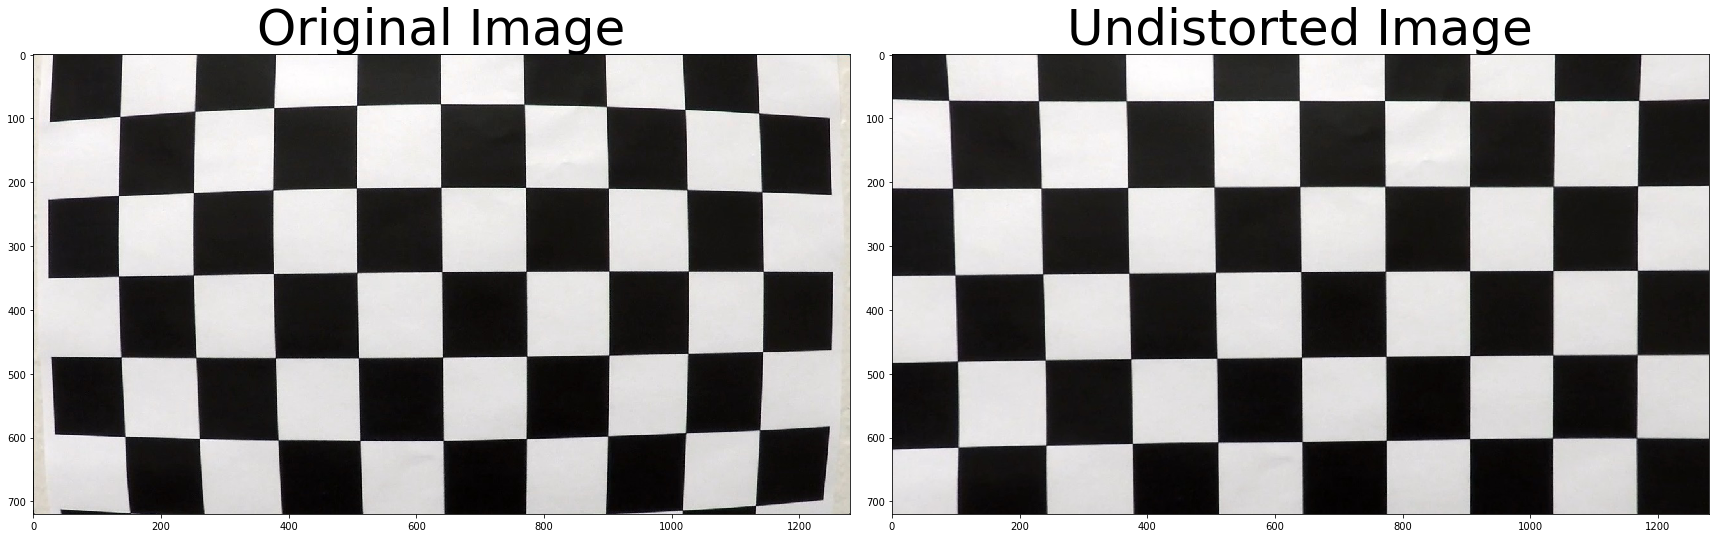

Undistorted image:


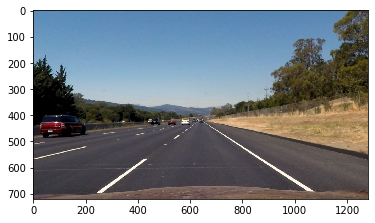

Grayscale image:


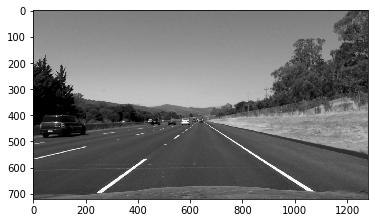

Sobelx, Gradient threshold:


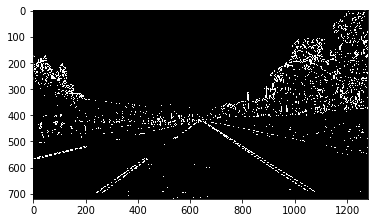

Grayscale image:


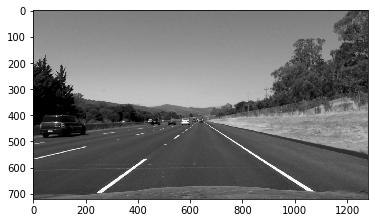

Sobely, Gradient threshold:


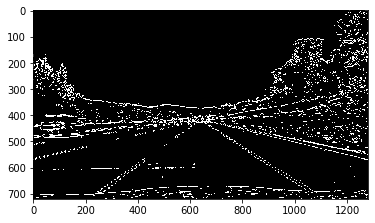

Gradient mag threshold:


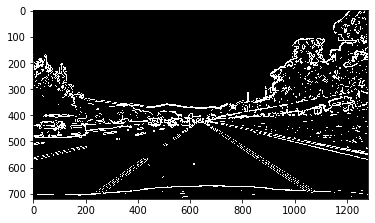

Gradient dir threshold:


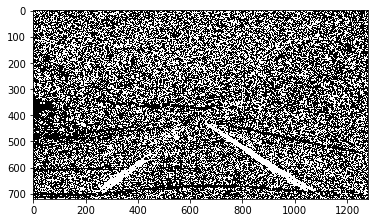

Combined grad threshold:


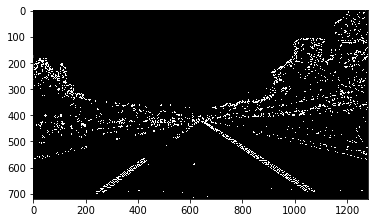

S channel:


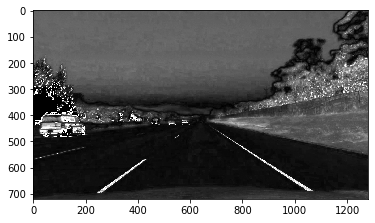

S threshold:


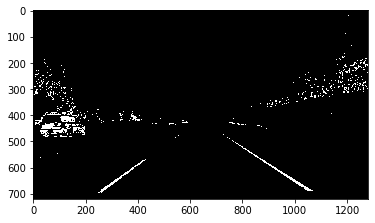

Masked binary image:


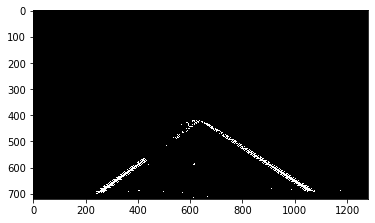

[(217, 719), (567, 470), (714, 470), (1108, 719)]
Line image:


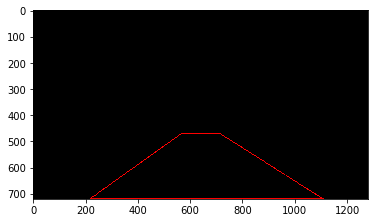

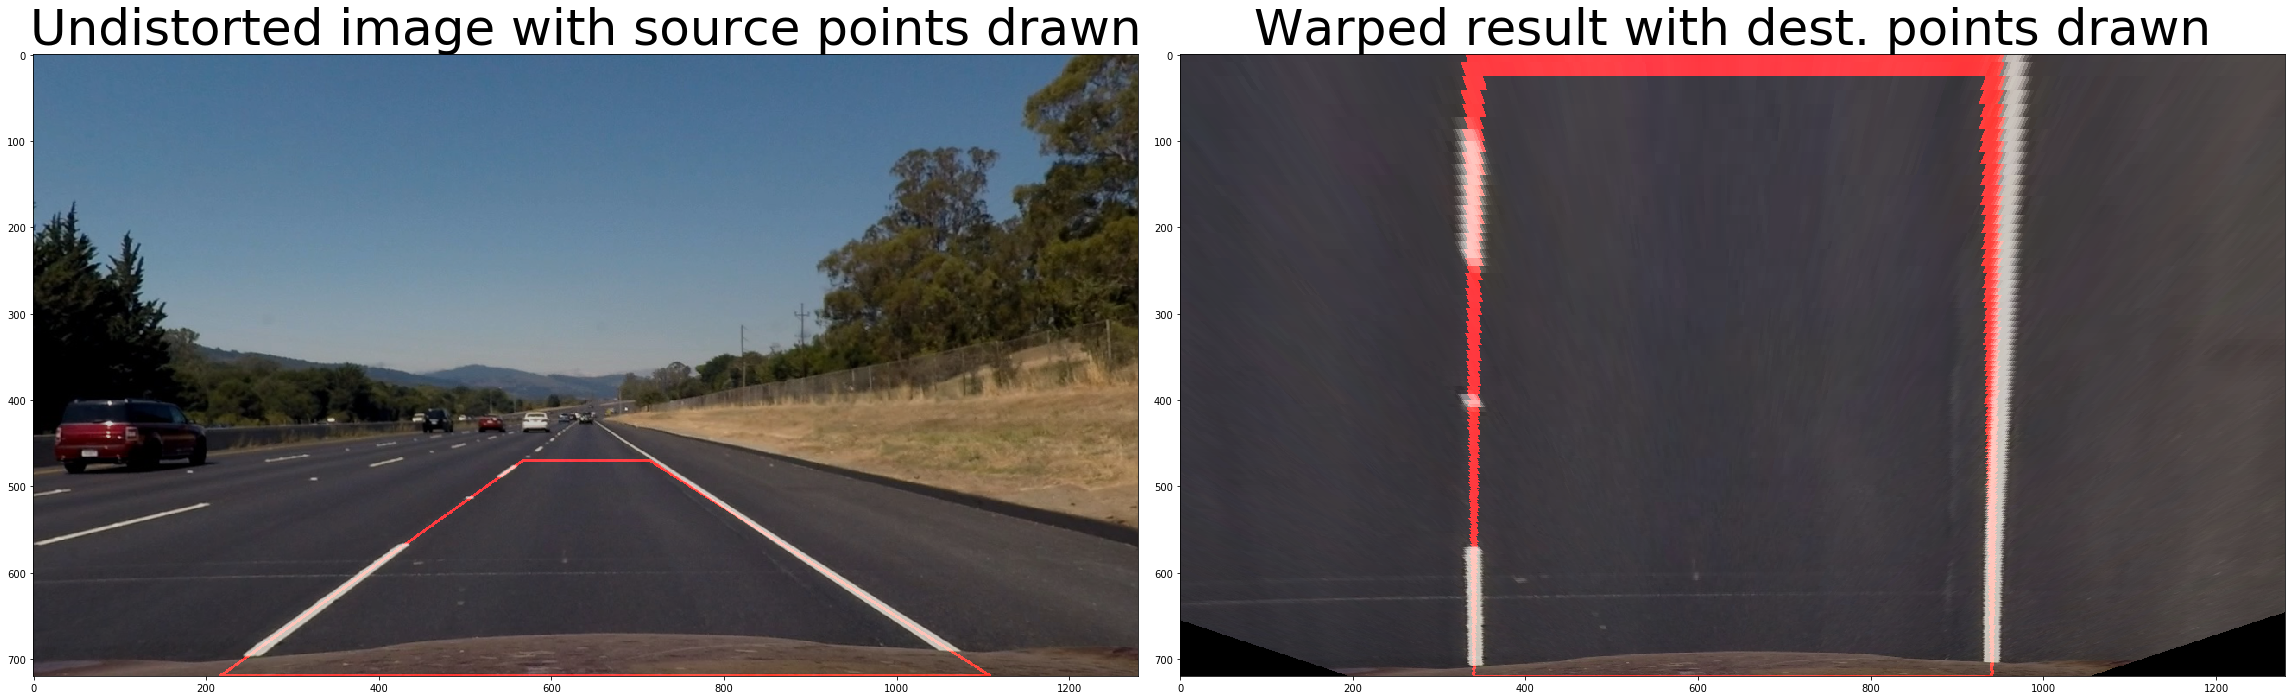

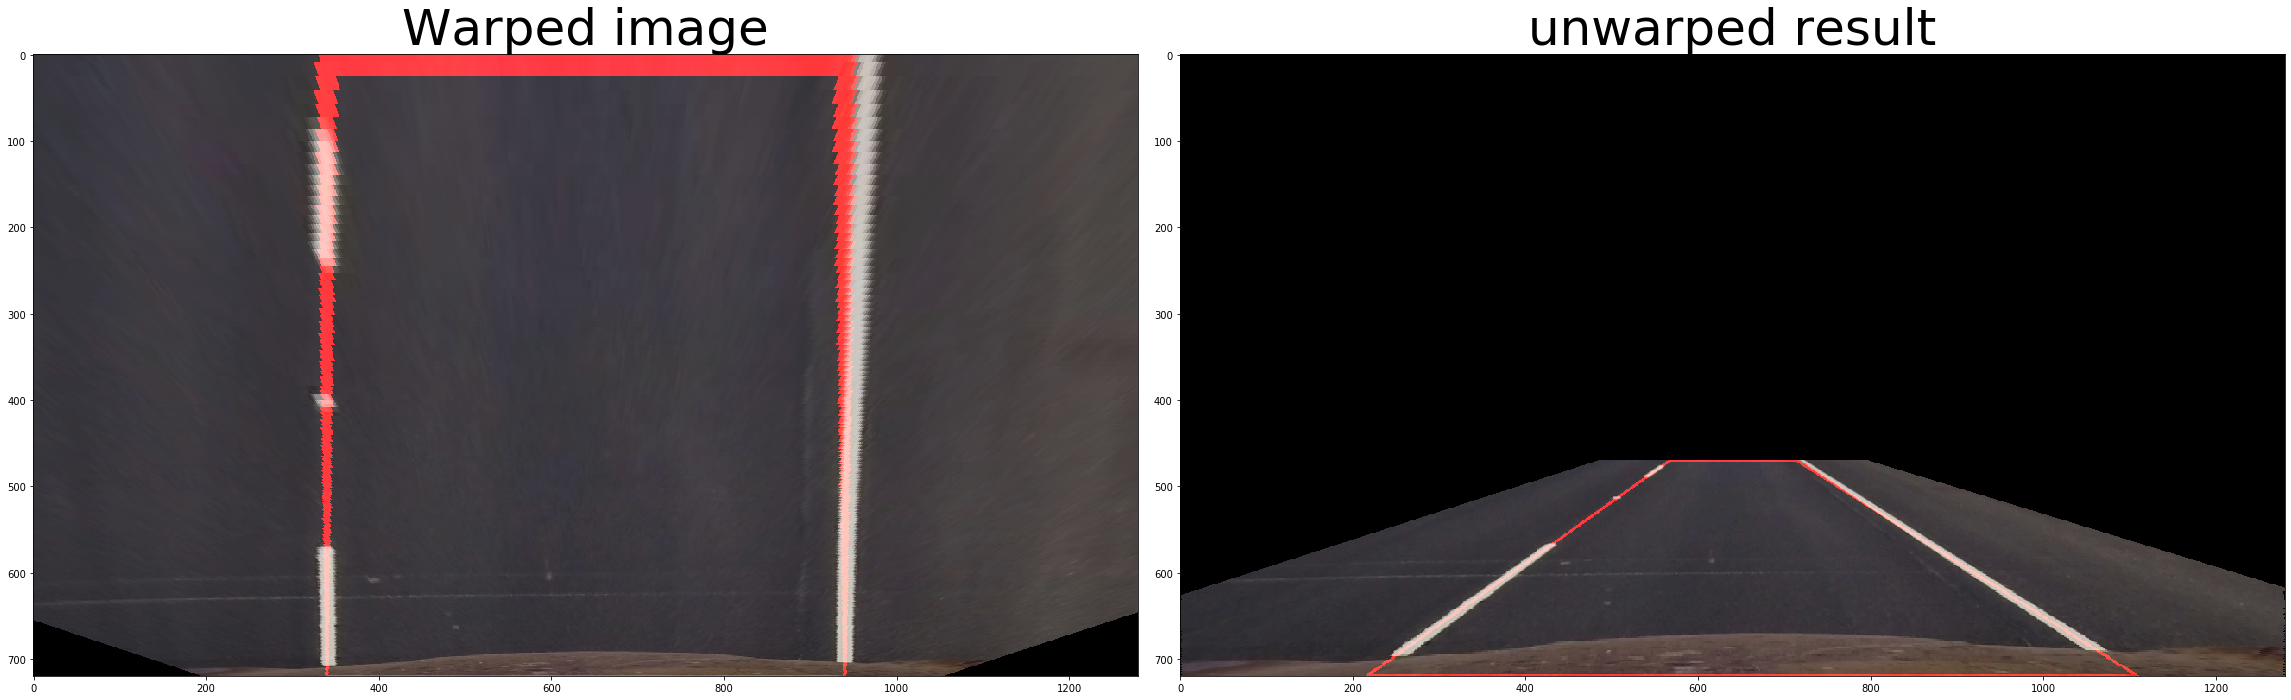

In [7]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)

        
fpath = "camera_cal/calibration1.jpg"
#extract basename from path fpath
fn = os.path.basename(fpath)

#read in a calibration image
img = mpimg.imread(fpath)
        
#apply camera calibration and distortion correction to calibration image
undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

#store original and undistorted calibration image as a figure to folder output_images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
f.savefig("output_images/undistort_output_{}".format(fn))
plt.show()


#compute the perspective transform once based on image with straight lines
#mark lane lines on undistorted and warped image
#preprocessing necessary (distortion correction, gradient+color thresholding and region masking)

fpath = "test_images/straight_lines2.jpg"
#extract basename from path fpath
fn = os.path.basename(fpath)

img = mpimg.imread(fpath)

rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 5   # maximum gap in pixels between connectable line segments

undist = cv2.undistort(img, mtx, dist, None, mtx)
print("Undistorted image:")
plt.imshow(undist)
plt.show()

binary_combo = color_gradient_thresholding(undist, sobel_kernel=15, s_thresh=(170, 255), thresh=(20, 100), thresh_mag=(30,100), thresh_dir=(0.7, 1.3))
imshape = img.shape
vertices = np.array([[(0,imshape[0]-1),(600, 420), (640, 420), (imshape[1]-1,imshape[0]-1)]], dtype=np.int32) #vertices of region of interest
masked_binary_combo = region_of_interest(binary_combo, vertices)
print("Masked binary image:")
plt.imshow(masked_binary_combo,cmap='gray')
plt.show()

#apply Hough transformation to thresholded image 
#i.e. create a line image 
line_image, intersection_vertices = hough_lines(masked_binary_combo, rho, theta, threshold, min_line_length, max_line_gap)
print("Line image:")
plt.imshow(line_image,cmap='gray')
plt.show()

# Draw the lines on the undistorted image
lines_undistorted = weighted_img(line_image, undist, α=0.8, β=1., γ=0.)

#calculate and apply perspective transform to lines_undistorted
src = np.float32(np.array(intersection_vertices))
dst = np.float32([[340,imshape[0]-1],[340,0],[940,0],[940,imshape[0]-1]])
warped, M = calc_perspective_trans_warp(lines_undistorted, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))
f.tight_layout()
ax1.imshow(lines_undistorted)
ax1.set_title("Undistorted image with source points drawn", fontsize=50)
ax2.imshow(warped)
ax2.set_title("Warped result with dest. points drawn", fontsize=50)
f.savefig("output_images/warped_{}".format(fn))
plt.show()


#calculate and apply inverse perspective transform to warped
unwarped, Minv = calc_perspective_trans_warp(warped, dst, src)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title("Warped image", fontsize=50)
ax2.imshow(unwarped)
ax2.set_title("unwarped result", fontsize=50)
plt.show()


## Pipeline for lane-line detection based on test images

Undistorted test image:


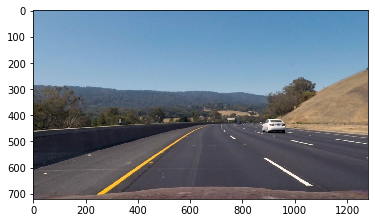

Grayscale image:


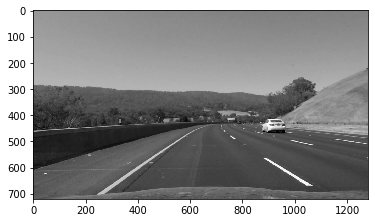

Sobelx, Gradient threshold:


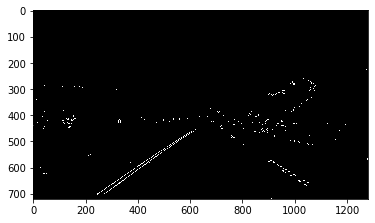

Grayscale image:


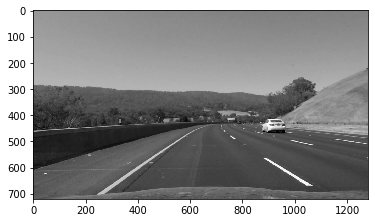

Sobely, Gradient threshold:


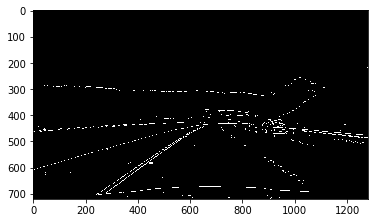

Gradient mag threshold:


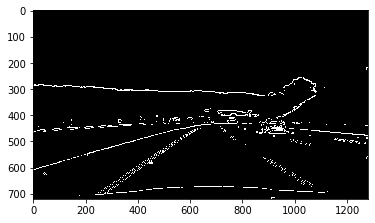

Gradient dir threshold:


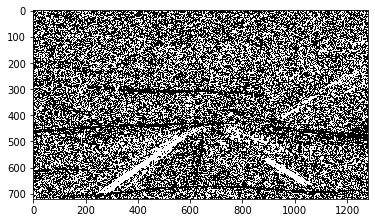

Combined grad threshold:


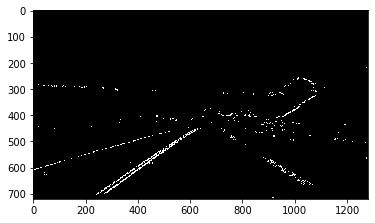

S channel:


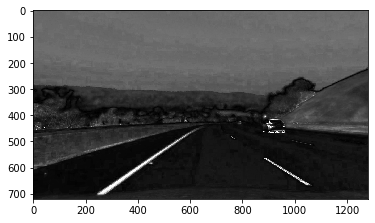

S threshold:


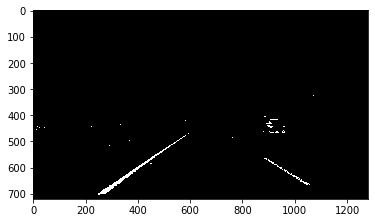

Binary Combo:


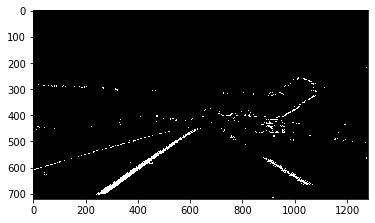

(720, 1280, 3)
Region of interest:


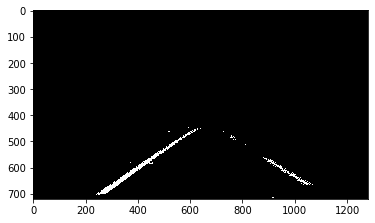

[(231, 719), (595, 470), (728, 470), (1137, 719)]
Line image:


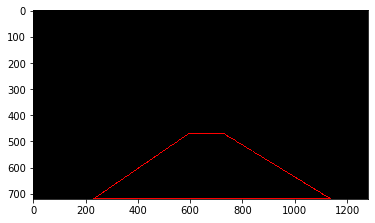

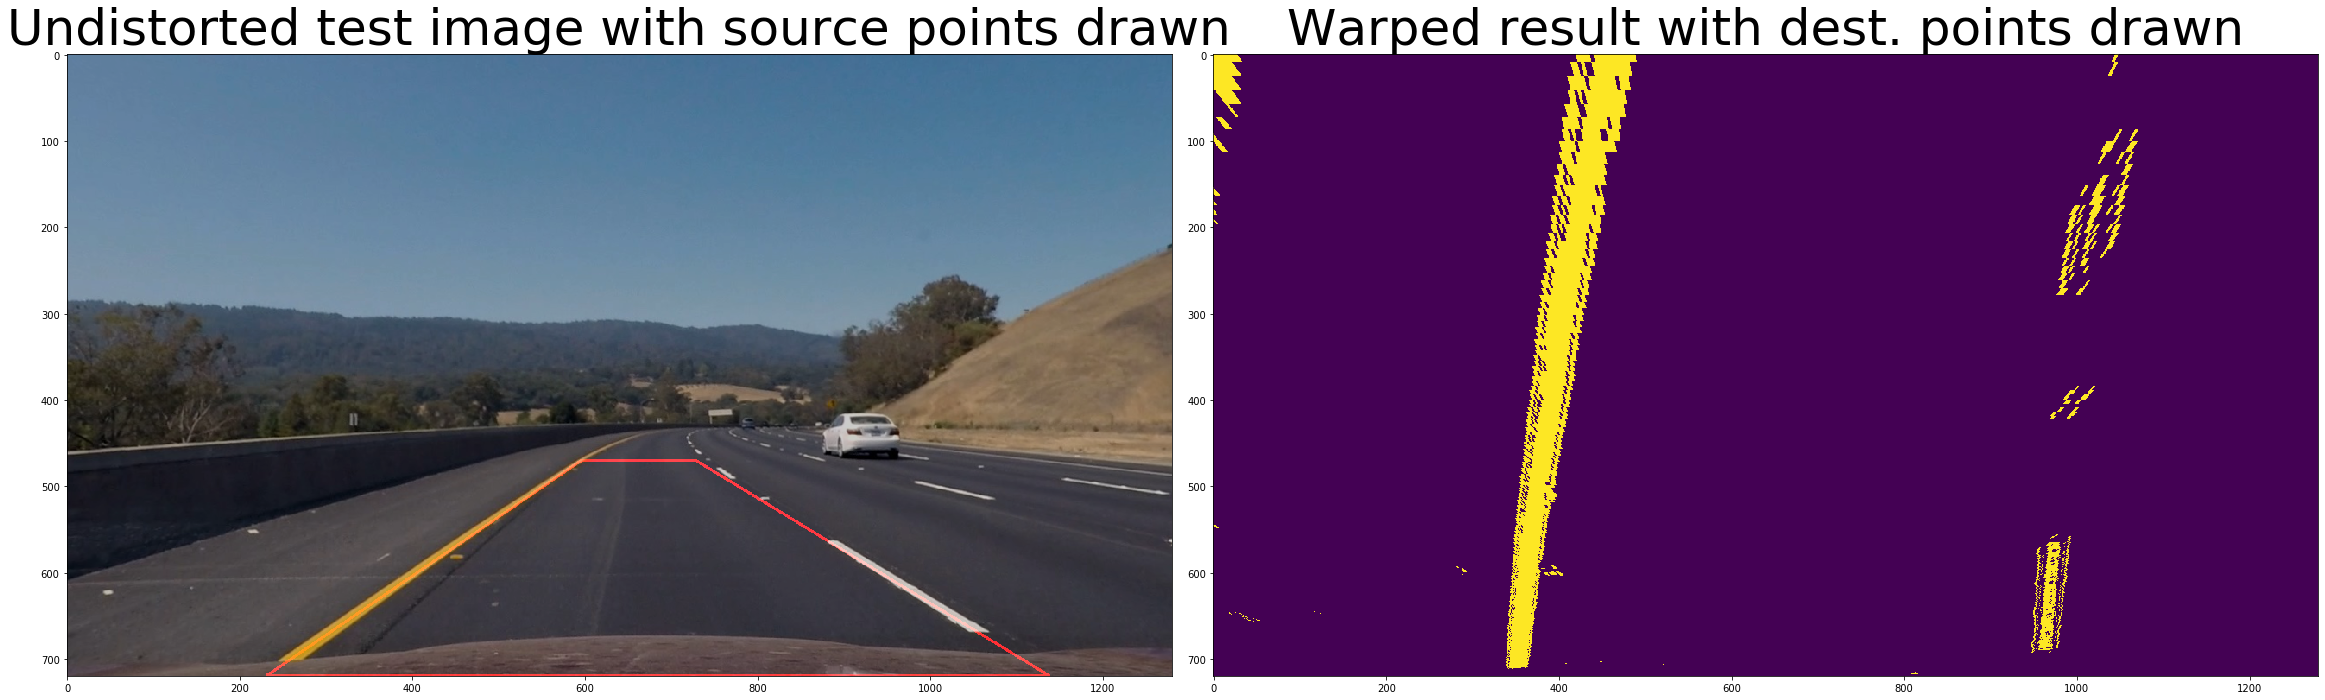

(23439,)
Color fit lines:


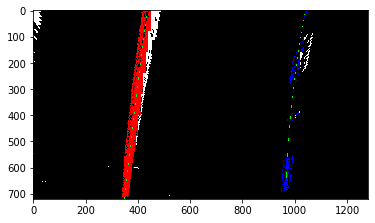

(23439,)
5635 m
-0.1665 m
Visualization of lane boundaries


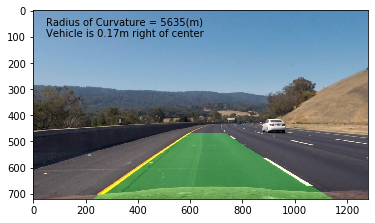

Undistorted test image:


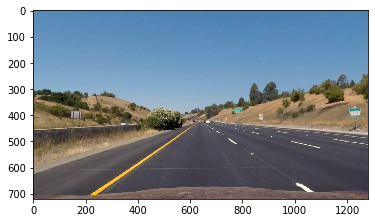

Grayscale image:


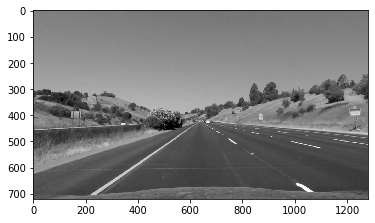

Sobelx, Gradient threshold:


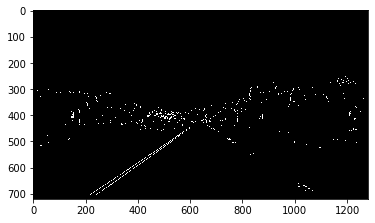

Grayscale image:


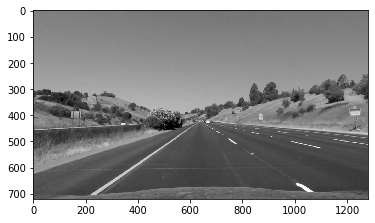

Sobely, Gradient threshold:


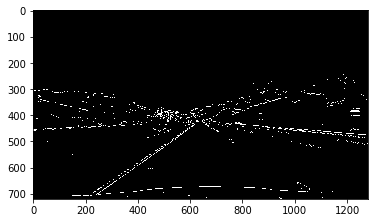

Gradient mag threshold:


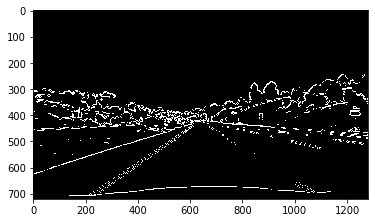

Gradient dir threshold:


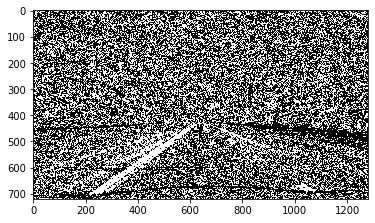

Combined grad threshold:


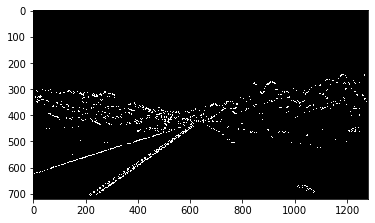

In [ ]:
# Make a list of test images
images = glob.glob('test_images/*.jpg')

for fname in images:
    
    img = mpimg.imread(fname)
    
    #extract basename from path fpath
    fn = os.path.basename(fname)
    
    #apply distortion correction to every test image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    print("Undistorted test image:")
    plt.imshow(undist)
    plt.show()
    
    #apply color and gradient thresholding
    binary_combo = color_gradient_thresholding(undist, sobel_kernel=15, s_thresh=(150, 255), thresh=(50, 100), thresh_mag=(50,100), thresh_dir=(0.7, 1.3))
    print("Binary Combo:")
    plt.imshow(binary_combo,cmap='gray')
    plt.imsave("output_images/binary_combo_{}".format(fn),binary_combo,cmap='gray')
    plt.show()
    
    #apply region of interest mask to consider only lane lines
    imshape = img.shape
    print(imshape)
    vertices = np.array([[(0,imshape[0]-1),(600, 420), (640, 420), (imshape[1]-1,imshape[0]-1)]], dtype=np.int32)
    masked_binary_combo = region_of_interest(binary_combo, vertices)
    print("Region of interest:")
    plt.imshow(masked_binary_combo, cmap='gray')
    plt.show()
    
    #apply Hough transformation to thresholded image 
    #i.e. create a line image 
    line_image, intersection_vertices = hough_lines(masked_binary_combo, rho, theta, threshold, min_line_length, max_line_gap)
    print("Line image:")
    plt.imshow(line_image,cmap='gray')
    plt.show()

    # Draw the lines on the undistorted image
    lines_undistorted = weighted_img(line_image, undist, α=0.8, β=1., γ=0.)
    
    #warp the undistorted image
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(binary_combo, M, img_size, flags=cv2.INTER_NEAREST)
    
    '''
    #draw vertical lines on warped image
    cv2.line(warped, (dst[0,0], dst[0,1]), (dst[1,0], dst[1,1]), (255,0,0), 2)
    cv2.line(warped, (dst[3,0], dst[3,1]), (dst[2,0], dst[2,1]), (255,0,0), 2)
    
    #draw horizontal lines on warped image
    cv2.line(warped, (dst[0,0], dst[0,1]), (dst[3,0], dst[3,1]), (255,0,0), 2)
    cv2.line(warped, (dst[1,0], dst[1,1]), (dst[2,0], dst[2,1]), (255,0,0), 2)
    '''
    
    '''
    #apply color and gradient thresholding to warped image
    binary_combo = color_gradient_thresholding(warped, sobel_kernel=29, s_thresh=(150, 255), thresh=(50, 100), thresh_mag=(50,100), thresh_dir=(0.7, 1.3))
    print("Binary combo warped:")
    plt.imshow(binary_combo,cmap='gray')
    plt.show()
    
    #apply region of interest mask to consider only lane lines
    imshape = img.shape
    print(imshape)
    vertices = np.array([[(0,imshape[0]-1),(0, 420), (640, 420), (imshape[1],imshape[0]-1)]], dtype=np.int32)
    masked_binary_combo = region_of_interest(binary_combo, vertices)
    print("Masked binary combo warped:")
    plt.imshow(masked_binary_combo,cmap='gray')
    plt.show()
    
    #apply Hough transformation to thresholded image 
    #i.e. create a line image 
    line_image, intersection_vertices = hough_lines(masked_binary_combo, rho, theta, threshold, min_line_length, max_line_gap)


    # Draw the lines on the undistorted image
    lines_warped = weighted_img(line_image, undist, α=0.8, β=1., γ=0.)
    '''
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))
    f.tight_layout()
    ax1.imshow(lines_undistorted)
    ax1.set_title("Undistorted test image with source points drawn", fontsize=50)
    ax2.imshow(warped)
    ax2.set_title("Warped result with dest. points drawn", fontsize=50)
    plt.show()
    
    
    #identification of lane line pixels and polynomial fit for left and right lane lines
    color_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped)
    print("Color fit lines:")
    plt.imshow(color_fit)
    plt.imsave("output_images/color_fit_lines_{}".format(fn),color_fit)
    plt.show()
    
    
    # Calculate the radius of curvature in meters for both lane lines
    avg_curverad = measure_curvature_real(warped)
    print(avg_curverad, 'm')
    
    # Calculate the position of the car in meters
    offset = measure_position_real(warped)
    print(offset, 'm')
    
    
    #Visualize lane boundaries on original image
    result = visualization_lane_bounds(Minv,undist,left_fitx,right_fitx,ploty,avg_curverad,offset)
    